# Trajectrory Prediction using LSTM

## Author: Deeksha, Divya, Isha

In this notebook we are trying to predict the next location of a user using the LSTM model.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
df = pd.read_csv("levelB1_trajectory.csv",header=0)

In [2]:
df.head()

,ClientMacAddr,just_date,len_,loc_info
0,36,2018-04-17,74,"[('LB1', 1.2902421999999998, 103.851585, '09:1..."
1,36,2018-04-18,450,"[('LB1', 1.2908487, 103.85196, '09:32:56'), ('..."
2,36,2018-05-30,285,"[('LB1', 1.2908455, 103.852005, '16:05:20'), (..."
3,36,2018-06-15,323,"[('LB1', 1.2901448999999998, 103.85152, '14:42..."
4,36,2018-06-23,8,"[('LB1', 1.2903761, 103.851555, '10:24:50'), (..."


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
import numpy as np
import math
import ast
import keras
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
def predict_next_location_ext_user(mac_id,level):
    if level=='B1':
        df = pd.read_csv("levelB1_trajectory.csv",header=0)
        
    data_mac_id = df[df['ClientMacAddr']==mac_id]
    trajectory = []
    for index, row in data_mac_id.iterrows():
        locInfo = ast.literal_eval(row['loc_info'])
        sequenceModelLat = []
        sequenceModelLong = []
        for i in range(len(locInfo)):
            #time = locInfo[i][3]
            lat = locInfo[i][1]
            long = locInfo[i][2]
            sequenceModelLat.append(lat)
            sequenceModelLong.append(long)
        #scale the values
        x_lat = pd.DataFrame(sequenceModelLat)
        x_long = pd.DataFrame(sequenceModelLong)
        valuesLat = x_lat.values 
        valuesLong = x_long.values
        print("Hello lat and long")
        print(valuesLat)
        print(valuesLat)
        x_lat_scaled = scaleX(valuesLat)
        x_long_scaled = scaleX(valuesLong)
        print("Hello scaled lat and long")
        print(x_lat_scaled)
        print(x_lat_scaled)
        reframed_lat = series_to_supervised(x_lat_scaled, 1, 1)
        reframed_long = series_to_supervised(x_long_scaled, 1, 1)
        pred_lat = train_model(reframed_lat) 
        pred_long = train_model(reframed_long)
        pred_point = (pred_lat[0],pred_long[0])
        rmse = (pred_lat[1],pred_long[1])
        trajectory.append((pred_point,rmse))
    return trajectory

In [4]:
def predict_next_location_ext_user1(mac_id,traj,level):
    if level=='B1':
        df = pd.read_csv("levelB1_trajectory.csv",header=0)
        
    data_mac_id = df[df['ClientMacAddr']==mac_id]
    minDistance = 9999999999999999999
    keyIndex = 0
    keyRow = 0
    for index, row in data_mac_id.iterrows():
        locInfo = ast.literal_eval(row['loc_info'])
        sumDist = 0
        sequenceModelLat_test = []
        sequenceModelLong_test = []
        for x in range(min(len(traj),3)):
            lat = locInfo[x][1]
            longg = locInfo[x][2]
            plat = traj[x][0]
            plong = traj[x][1]
            sequenceModelLat_test.append(plat)
            sequenceModelLong_test.append(plong)            
            dist = math.hypot(plat - lat, plong - longg)
            sumDist += dist
        if sumDist < minDistance:
            minDistance = min(minDistance, dist)
            keyIndex = index
            keyRow = row
    for row in keyRow:
        locInfo = ast.literal_eval(row)    
        sequenceModelLat = []
        sequenceModelLong = []
        for i in range(len(locInfo)):
            #time = locInfo[i][3]
            lat = locInfo[i][1]
            longg = locInfo[i][2]
            sequenceModelLat.append(lat)
            sequenceModelLong.append(long)
        #scale the train values
        x_lat = pd.DataFrame(sequenceModelLat)
        x_long = pd.DataFrame(sequenceModelLong)
        valuesLat = x_lat.values 
        valuesLong = x_long.values
        x_lat_scaled = scaleX(valuesLat)
        x_long_scaled = scaleX(valuesLong)
        reframed_lat = series_to_supervised(x_lat_scaled, 1, 1)
        reframed_long = series_to_supervised(x_long_scaled, 1, 1)
        #scaled the test values
        xtest_lat = pd.DataFrame(sequenceModelLat_test)
        xtest_long = pd.DataFrame(sequenceModelLong_test)
        valuesLat_test = xtest_lat.values 
        valuesLong_test = xtest_long.values
        x_lat_scaled_test = scaleX(valuesLat_test)
        x_long_scaled_test = scaleX(valuesLong_test)
        reframed_lat_test = series_to_supervised(x_lat_scaled_test, 1, 1)
        reframed_long_test = series_to_supervised(x_long_scaled_test, 1, 1)
        #train the model 
        pred_lat = train_model1(reframed_lat,reframed_lat_test) 
        pred_long = train_model1(reframed_long,reframed_long_test)
        pred_point = (pred_lat[0],pred_long[0])
        trajectory.append(pred_point)

In [3]:
def train_model1(reframed,test_ref):
    values = reframed.values
    values_test = test_ref.values
    #n_train_time = 0.7 * len(values)
    train = values
    test = values_test
    train_X, train_y = train[:, :1], train[:, 1:]
    test_X= test[:, :]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #train the model
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    #    model.add(LSTM(70))
    #    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # make a prediction
    yhat = model.predict(test_X)
    pred_y = yhat[len(yhat)-1]
    return (pred_y,rmse)

In [5]:
def scaleX(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

In [6]:
def train_model(reframed):
    values = reframed.values
    #print(values)
    n_train_time = int(0.7 * len(values))
    print(n_train_time)
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    train_X, train_y = train[:, :1], train[:, 1:]
    test_X, test_y = test[:, :1], test[:,1:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #train the model
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    #    model.add(LSTM(70))
    #    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # make a prediction
    yhat = model.predict(test_X)
    pred_y = yhat[len(yhat)-1]
    rmse = math.sqrt(mean_squared_error(yhat, test_y))   
    return (pred_y,rmse)




### LSTM and Loss Functions on Level B1 dataset

Hello lat and long
[[1.2902422]
 [1.2902025]
 [1.290194 ]
 [1.2902478]
 [1.2902243]
 [1.2902343]
 [1.290242 ]
 [1.2902416]
 [1.2902374]
 [1.2902374]
 [1.290242 ]
 [1.290242 ]
 [1.2902374]
 [1.2902554]
 [1.2902381]
 [1.2901952]
 [1.2902391]
 [1.2902391]
 [1.2902381]
 [1.2902381]
 [1.2902381]
 [1.2902374]
 [1.2902374]
 [1.2902392]
 [1.2902392]
 [1.2902291]
 [1.2902519]
 [1.2902291]
 [1.2902553]
 [1.2902741]
 [1.2902529]
 [1.2902333]
 [1.2902538]
 [1.2902538]
 [1.2902538]
 [1.2901946]
 [1.2901726]
 [1.2902241]
 [1.290238 ]
 [1.2902544]
 [1.2902551]
 [1.2902551]
 [1.2902551]
 [1.2902551]
 [1.2902551]
 [1.2902402]
 [1.2902551]
 [1.2902492]
 [1.2902492]
 [1.2902354]
 [1.2902341]
 [1.2902306]
 [1.2902306]
 [1.2902306]
 [1.2902217]
 [1.2902217]
 [1.2902217]
 [1.2902217]
 [1.29022  ]
 [1.29022  ]
 [1.29022  ]
 [1.2901384]
 [1.2901161]
 [1.2901161]
 [1.2901161]
 [1.2900465]
 [1.2901057]
 [1.2900673]
 [1.29005  ]
 [1.2900376]
 [1.2900376]
 [1.2900279]
 [1.2899445]
 [1.2898891]
 [1.2898891]
 [1.28

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 132 samples, validate on 57 samples
Epoch 1/20
 - 2s - loss: 0.4482 - val_loss: 0.2981
Epoch 2/20
 - 0s - loss: 0.4360 - val_loss: 0.2891
Epoch 3/20
 - 0s - loss: 0.4216 - val_loss: 0.2806
Epoch 4/20
 - 0s - loss: 0.4098 - val_loss: 0.2724
Epoch 5/20
 - 0s - loss: 0.3973 - val_loss: 0.2643
Epoch 6/20
 - 0s - loss: 0.3882 - val_loss: 0.2565
Epoch 7/20
 - 0s - loss: 0.3748 - val_loss: 0.2489
Epoch 8/20
 - 0s - loss: 0.3647 - val_loss: 0.2414
Epoch 9/20
 - 0s - loss: 0.3516 - val_loss: 0.2341
Epoch 10/20
 - 0s - loss: 0.3441 - val_loss: 0.2270
Epoch 11/20
 - 0s - loss: 0.3333 - val_loss: 0.2200
Epoch 12/20
 - 0s - loss: 0.3240 - val_loss: 0.2132
Epoch 13/20
 - 0s - loss: 0.3131 - val_loss: 0.2066
Epoch 14/20
 - 0s - loss: 0.3032 - val_loss: 0.2000
Epoch 15/20
 - 0s - loss: 0.2921 - val_loss: 0.1936
Epoch 16/20
 - 0s - l

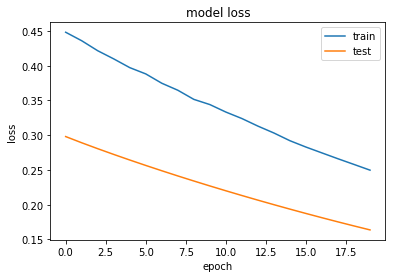

132
Train on 132 samples, validate on 57 samples
Epoch 1/20
 - 1s - loss: 0.5072 - val_loss: 0.3413
Epoch 2/20
 - 0s - loss: 0.4923 - val_loss: 0.3305
Epoch 3/20
 - 0s - loss: 0.4780 - val_loss: 0.3202
Epoch 4/20
 - 0s - loss: 0.4610 - val_loss: 0.3101
Epoch 5/20
 - 0s - loss: 0.4462 - val_loss: 0.3004
Epoch 6/20
 - 0s - loss: 0.4331 - val_loss: 0.2909
Epoch 7/20
 - 0s - loss: 0.4219 - val_loss: 0.2816
Epoch 8/20
 - 0s - loss: 0.4075 - val_loss: 0.2726
Epoch 9/20
 - 0s - loss: 0.3945 - val_loss: 0.2638
Epoch 10/20
 - 0s - loss: 0.3864 - val_loss: 0.2552
Epoch 11/20
 - 0s - loss: 0.3721 - val_loss: 0.2468
Epoch 12/20
 - 0s - loss: 0.3601 - val_loss: 0.2386
Epoch 13/20
 - 0s - loss: 0.3452 - val_loss: 0.2306
Epoch 14/20
 - 0s - loss: 0.3366 - val_loss: 0.2228
Epoch 15/20
 - 0s - loss: 0.3266 - val_loss: 0.2151
Epoch 16/20
 - 0s - loss: 0.3135 - val_loss: 0.2076
Epoch 17/20
 - 0s - loss: 0.3039 - val_loss: 0.2003
Epoch 18/20
 - 0s - loss: 0.2937 - val_loss: 0.1932
Epoch 19/20
 - 0s - loss

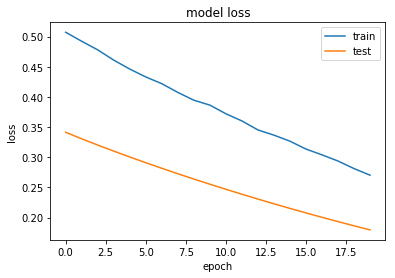

Hello lat and long
[[1.2908487]
 [1.2908539]
 [1.2908516]
 ...
 [1.2903473]
 [1.2903473]
 [1.2903473]]
[[1.2908487]
 [1.2908539]
 [1.2908516]
 ...
 [1.2903473]
 [1.2903473]
 [1.2903473]]
Hello scaled lat and long
[[0.99204939]
 [0.99691329]
 [0.99476195]
 ...
 [0.52305678]
 [0.52305678]
 [0.52305678]]
[[0.99204939]
 [0.99691329]
 [0.99476195]
 ...
 [0.52305678]
 [0.52305678]
 [0.52305678]]
826
Train on 826 samples, validate on 354 samples
Epoch 1/20
 - 1s - loss: 0.3066 - val_loss: 0.1138
Epoch 2/20
 - 0s - loss: 0.2476 - val_loss: 0.0829
Epoch 3/20
 - 0s - loss: 0.1971 - val_loss: 0.0575
Epoch 4/20
 - 0s - loss: 0.1530 - val_loss: 0.0374
Epoch 5/20
 - 0s - loss: 0.1146 - val_loss: 0.0236
Epoch 6/20
 - 0s - loss: 0.0850 - val_loss: 0.0162
Epoch 7/20
 - 0s - loss: 0.0634 - val_loss: 0.0146
Epoch 8/20
 - 0s - loss: 0.0489 - val_loss: 0.0165
Epoch 9/20
 - 0s - loss: 0.0412 - val_loss: 0.0195
Epoch 10/20
 - 0s - loss: 0.0369 - val_loss: 0.0219
Epoch 11/20
 - 0s - loss: 0.0345 - val_loss: 0

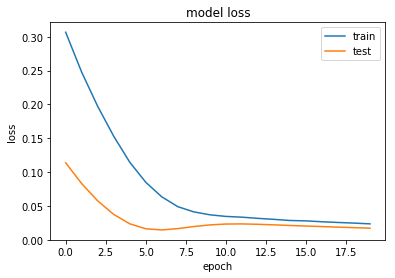

826
Train on 826 samples, validate on 354 samples
Epoch 1/20
 - 1s - loss: 0.2134 - val_loss: 0.0516
Epoch 2/20
 - 0s - loss: 0.1679 - val_loss: 0.0331
Epoch 3/20
 - 0s - loss: 0.1308 - val_loss: 0.0197
Epoch 4/20
 - 0s - loss: 0.0997 - val_loss: 0.0113
Epoch 5/20
 - 0s - loss: 0.0745 - val_loss: 0.0077
Epoch 6/20
 - 0s - loss: 0.0569 - val_loss: 0.0082
Epoch 7/20
 - 0s - loss: 0.0455 - val_loss: 0.0110
Epoch 8/20
 - 0s - loss: 0.0376 - val_loss: 0.0143
Epoch 9/20
 - 0s - loss: 0.0343 - val_loss: 0.0169
Epoch 10/20
 - 0s - loss: 0.0313 - val_loss: 0.0183
Epoch 11/20
 - 0s - loss: 0.0300 - val_loss: 0.0186
Epoch 12/20
 - 0s - loss: 0.0280 - val_loss: 0.0182
Epoch 13/20
 - 0s - loss: 0.0269 - val_loss: 0.0175
Epoch 14/20
 - 0s - loss: 0.0257 - val_loss: 0.0167
Epoch 15/20
 - 0s - loss: 0.0244 - val_loss: 0.0159
Epoch 16/20
 - 0s - loss: 0.0232 - val_loss: 0.0151
Epoch 17/20
 - 0s - loss: 0.0227 - val_loss: 0.0145
Epoch 18/20
 - 0s - loss: 0.0202 - val_loss: 0.0136
Epoch 19/20
 - 0s - los

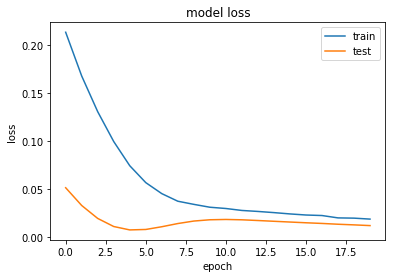

Hello lat and long
[[1.2908455]
 [1.2908463]
 [1.2908523]
 [1.2908523]
 [1.2908523]
 [1.2908498]
 [1.2908461]
 [1.2908461]
 [1.2908461]
 [1.2908477]
 [1.2908413]
 [1.2908434]
 [1.2908471]
 [1.2908475]
 [1.2908255]
 [1.2908499]
 [1.2908404]
 [1.29085  ]
 [1.29085  ]
 [1.2908474]
 [1.2908474]
 [1.2908474]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908494]
 [1.2908441]
 [1.2908441]
 [1.2908441]
 [1.2908471]
 [1.2908466]
 [1.2908466]
 [1.290847 ]
 [1.290847 ]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.290847 ]
 [1.290847 ]
 [1.290847 ]
 [1.290847 ]
 [1.2908466]
 [1.2908499]
 [1.2908441]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908494]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908471]
 [1.2908438]
 [1.290847 ]
 [1.2908471]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.2908466]
 [1.29

Train on 644 samples, validate on 277 samples
Epoch 1/20
 - 1s - loss: 0.3695 - val_loss: 0.0599
Epoch 2/20
 - 0s - loss: 0.3019 - val_loss: 0.0400
Epoch 3/20
 - 0s - loss: 0.2439 - val_loss: 0.0246
Epoch 4/20
 - 0s - loss: 0.1926 - val_loss: 0.0138
Epoch 5/20
 - 0s - loss: 0.1484 - val_loss: 0.0079
Epoch 6/20
 - 0s - loss: 0.1129 - val_loss: 0.0069
Epoch 7/20
 - 0s - loss: 0.0839 - val_loss: 0.0100
Epoch 8/20
 - 0s - loss: 0.0628 - val_loss: 0.0157
Epoch 9/20
 - 0s - loss: 0.0498 - val_loss: 0.0223
Epoch 10/20
 - 0s - loss: 0.0427 - val_loss: 0.0279
Epoch 11/20
 - 0s - loss: 0.0383 - val_loss: 0.0316
Epoch 12/20
 - 0s - loss: 0.0355 - val_loss: 0.0331
Epoch 13/20
 - 0s - loss: 0.0337 - val_loss: 0.0332
Epoch 14/20
 - 0s - loss: 0.0314 - val_loss: 0.0323
Epoch 15/20
 - 0s - loss: 0.0310 - val_loss: 0.0310
Epoch 16/20
 - 0s - loss: 0.0294 - val_loss: 0.0295
Epoch 17/20
 - 0s - loss: 0.0285 - val_loss: 0.0280
Epoch 18/20
 - 0s - loss: 0.0270 - val_loss: 0.0267
Epoch 19/20
 - 0s - loss: 0

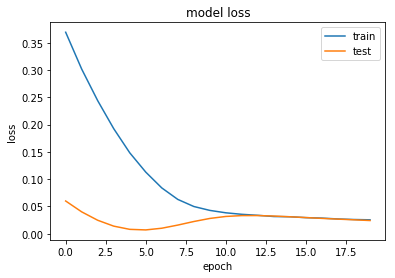

644
Train on 644 samples, validate on 277 samples
Epoch 1/20
 - 1s - loss: 0.4732 - val_loss: 0.0235
Epoch 2/20
 - 0s - loss: 0.3984 - val_loss: 0.0145
Epoch 3/20
 - 0s - loss: 0.3354 - val_loss: 0.0087
Epoch 4/20
 - 0s - loss: 0.2756 - val_loss: 0.0061
Epoch 5/20
 - 0s - loss: 0.2238 - val_loss: 0.0068
Epoch 6/20
 - 0s - loss: 0.1781 - val_loss: 0.0110
Epoch 7/20
 - 0s - loss: 0.1391 - val_loss: 0.0182
Epoch 8/20
 - 0s - loss: 0.1070 - val_loss: 0.0277
Epoch 9/20
 - 0s - loss: 0.0837 - val_loss: 0.0382
Epoch 10/20
 - 0s - loss: 0.0673 - val_loss: 0.0482
Epoch 11/20
 - 0s - loss: 0.0556 - val_loss: 0.0565
Epoch 12/20
 - 0s - loss: 0.0481 - val_loss: 0.0620
Epoch 13/20
 - 0s - loss: 0.0436 - val_loss: 0.0649
Epoch 14/20
 - 0s - loss: 0.0403 - val_loss: 0.0655
Epoch 15/20
 - 0s - loss: 0.0372 - val_loss: 0.0645
Epoch 16/20
 - 0s - loss: 0.0358 - val_loss: 0.0625
Epoch 17/20
 - 0s - loss: 0.0337 - val_loss: 0.0598
Epoch 18/20
 - 0s - loss: 0.0317 - val_loss: 0.0568
Epoch 19/20
 - 0s - los

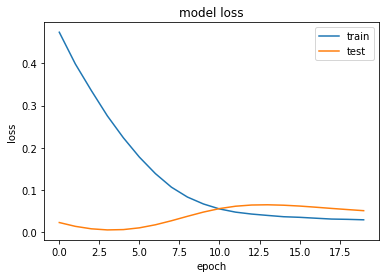

Hello lat and long
[[1.2901449]
 [1.2901365]
 [1.2901391]
 [1.29026  ]
 [1.290253 ]
 [1.2902483]
 [1.2902403]
 [1.2902455]
 [1.2902416]
 [1.2901667]
 [1.2902622]
 [1.2901993]
 [1.2901785]
 [1.2902429]
 [1.290386 ]
 [1.2903982]
 [1.2903237]
 [1.2904357]
 [1.2904357]
 [1.2901993]
 [1.2901832]
 [1.2901832]
 [1.2901832]
 [1.2901655]
 [1.2901655]
 [1.2901565]
 [1.2901732]
 [1.290146 ]
 [1.2901765]
 [1.2901736]
 [1.2901448]
 [1.2901448]
 [1.2901607]
 [1.2902564]
 [1.2902321]
 [1.2901607]
 [1.2901607]
 [1.2901506]
 [1.2901547]
 [1.2901547]
 [1.2901486]
 [1.2901512]
 [1.2901525]
 [1.2901255]
 [1.29024  ]
 [1.2901579]
 [1.2901603]
 [1.2901622]
 [1.2901622]
 [1.2901953]
 [1.2901121]
 [1.2901622]
 [1.2901618]
 [1.2901618]
 [1.2901618]
 [1.2901596]
 [1.2902353]
 [1.2901961]
 [1.2901795]
 [1.2901789]
 [1.2901703]
 [1.2901661]
 [1.2901878]
 [1.2901161]
 [1.2901227]
 [1.290116 ]
 [1.290127 ]
 [1.2901173]
 [1.290116 ]
 [1.2901173]
 [1.2901427]
 [1.2901062]
 [1.2901102]
 [1.2901075]
 [1.2901111]
 [1.29

Train on 503 samples, validate on 216 samples
Epoch 1/20
 - 2s - loss: 0.4379 - val_loss: 0.0831
Epoch 2/20
 - 0s - loss: 0.3896 - val_loss: 0.0665
Epoch 3/20
 - 0s - loss: 0.3429 - val_loss: 0.0520
Epoch 4/20
 - 0s - loss: 0.3011 - val_loss: 0.0396
Epoch 5/20
 - 0s - loss: 0.2621 - val_loss: 0.0293
Epoch 6/20
 - 0s - loss: 0.2267 - val_loss: 0.0210
Epoch 7/20
 - 0s - loss: 0.1938 - val_loss: 0.0149
Epoch 8/20
 - 0s - loss: 0.1648 - val_loss: 0.0111
Epoch 9/20
 - 0s - loss: 0.1368 - val_loss: 0.0095
Epoch 10/20
 - 0s - loss: 0.1148 - val_loss: 0.0100
Epoch 11/20
 - 0s - loss: 0.0976 - val_loss: 0.0120
Epoch 12/20
 - 0s - loss: 0.0814 - val_loss: 0.0151
Epoch 13/20
 - 0s - loss: 0.0702 - val_loss: 0.0187
Epoch 14/20
 - 0s - loss: 0.0641 - val_loss: 0.0222
Epoch 15/20
 - 0s - loss: 0.0587 - val_loss: 0.0253
Epoch 16/20
 - 0s - loss: 0.0526 - val_loss: 0.0275
Epoch 17/20
 - 0s - loss: 0.0503 - val_loss: 0.0289
Epoch 18/20
 - 0s - loss: 0.0473 - val_loss: 0.0296
Epoch 19/20
 - 0s - loss: 0

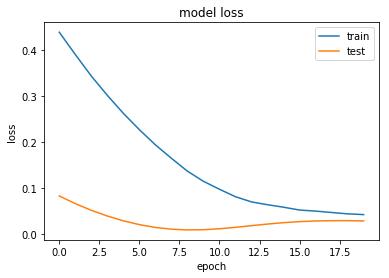

503
Train on 503 samples, validate on 216 samples
Epoch 1/20
 - 2s - loss: 0.4060 - val_loss: 0.0507
Epoch 2/20
 - 0s - loss: 0.3594 - val_loss: 0.0388
Epoch 3/20
 - 0s - loss: 0.3214 - val_loss: 0.0289
Epoch 4/20
 - 0s - loss: 0.2851 - val_loss: 0.0209
Epoch 5/20
 - 0s - loss: 0.2531 - val_loss: 0.0147
Epoch 6/20
 - 0s - loss: 0.2221 - val_loss: 0.0103
Epoch 7/20
 - 0s - loss: 0.1930 - val_loss: 0.0075
Epoch 8/20
 - 0s - loss: 0.1697 - val_loss: 0.0064
Epoch 9/20
 - 0s - loss: 0.1494 - val_loss: 0.0068
Epoch 10/20
 - 0s - loss: 0.1292 - val_loss: 0.0084
Epoch 11/20
 - 0s - loss: 0.1130 - val_loss: 0.0111
Epoch 12/20
 - 0s - loss: 0.1018 - val_loss: 0.0144
Epoch 13/20
 - 0s - loss: 0.0910 - val_loss: 0.0180
Epoch 14/20
 - 0s - loss: 0.0834 - val_loss: 0.0215
Epoch 15/20
 - 0s - loss: 0.0757 - val_loss: 0.0246
Epoch 16/20
 - 0s - loss: 0.0696 - val_loss: 0.0271
Epoch 17/20
 - 0s - loss: 0.0640 - val_loss: 0.0289
Epoch 18/20
 - 0s - loss: 0.0628 - val_loss: 0.0300
Epoch 19/20
 - 0s - los

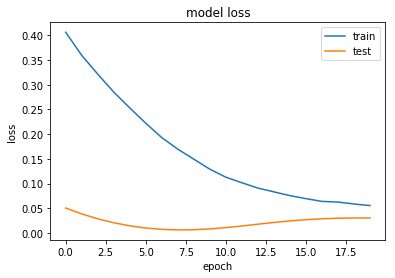

Hello lat and long
[[1.2903761]
 [1.29025  ]
 [1.29025  ]
 [1.289986 ]
 [1.289986 ]
 [1.289986 ]
 [1.2899381]
 [1.2899381]
 [1.2899629]
 [1.290356 ]
 [1.2906548]
 [1.2906548]
 [1.2901864]]
[[1.2903761]
 [1.29025  ]
 [1.29025  ]
 [1.289986 ]
 [1.289986 ]
 [1.289986 ]
 [1.2899381]
 [1.2899381]
 [1.2899629]
 [1.290356 ]
 [1.2906548]
 [1.2906548]
 [1.2901864]]
Hello scaled lat and long
[[0.61113437]
 [0.43518906]
 [0.43518906]
 [0.0668341 ]
 [0.0668341 ]
 [0.0668341 ]
 [0.        ]
 [0.        ]
 [0.03460304]
 [0.58308916]
 [1.        ]
 [1.        ]
 [0.346449  ]]
[[0.61113437]
 [0.43518906]
 [0.43518906]
 [0.0668341 ]
 [0.0668341 ]
 [0.0668341 ]
 [0.        ]
 [0.        ]
 [0.03460304]
 [0.58308916]
 [1.        ]
 [1.        ]
 [0.346449  ]]
8
Train on 8 samples, validate on 4 samples
Epoch 1/20
 - 2s - loss: 0.0508 - val_loss: 0.6104
Epoch 2/20
 - 0s - loss: 0.0488 - val_loss: 0.6006
Epoch 3/20
 - 0s - loss: 0.0448 - val_loss: 0.5911
Epoch 4/20
 - 0s - loss: 0.0461 - val_loss: 0.5817
E

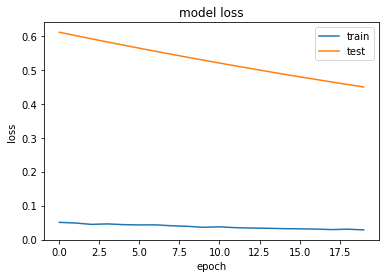

8
Train on 8 samples, validate on 4 samples
Epoch 1/20
 - 2s - loss: 0.0709 - val_loss: 0.5784
Epoch 2/20
 - 0s - loss: 0.0682 - val_loss: 0.5685
Epoch 3/20
 - 0s - loss: 0.0674 - val_loss: 0.5587
Epoch 4/20
 - 0s - loss: 0.0646 - val_loss: 0.5490
Epoch 5/20
 - 0s - loss: 0.0620 - val_loss: 0.5396
Epoch 6/20
 - 0s - loss: 0.0610 - val_loss: 0.5302
Epoch 7/20
 - 0s - loss: 0.0584 - val_loss: 0.5209
Epoch 8/20
 - 0s - loss: 0.0559 - val_loss: 0.5118
Epoch 9/20
 - 0s - loss: 0.0529 - val_loss: 0.5027
Epoch 10/20
 - 0s - loss: 0.0510 - val_loss: 0.4938
Epoch 11/20
 - 0s - loss: 0.0507 - val_loss: 0.4850
Epoch 12/20
 - 0s - loss: 0.0470 - val_loss: 0.4763
Epoch 13/20
 - 0s - loss: 0.0446 - val_loss: 0.4678
Epoch 14/20
 - 0s - loss: 0.0438 - val_loss: 0.4593
Epoch 15/20
 - 0s - loss: 0.0435 - val_loss: 0.4510
Epoch 16/20
 - 0s - loss: 0.0411 - val_loss: 0.4428
Epoch 17/20
 - 0s - loss: 0.0380 - val_loss: 0.4347
Epoch 18/20
 - 0s - loss: 0.0365 - val_loss: 0.4268
Epoch 19/20
 - 0s - loss: 0.0

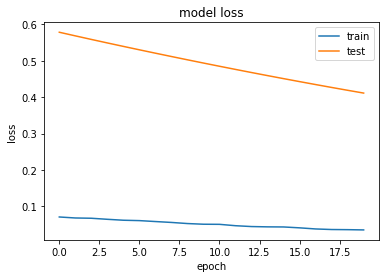

Hello lat and long
[[1.2905153]
 [1.2901573]
 [1.290555 ]
 [1.290555 ]
 [1.2908764]
 [1.2901031]
 [1.2901031]
 [1.290237 ]]
[[1.2905153]
 [1.2901573]
 [1.290555 ]
 [1.290555 ]
 [1.2908764]
 [1.2901031]
 [1.2901031]
 [1.290237 ]]
Hello scaled lat and long
[[0.53304022]
 [0.07008923]
 [0.58437864]
 [0.58437864]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.17315402]]
[[0.53304022]
 [0.07008923]
 [0.58437864]
 [0.58437864]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.17315402]]
4
Train on 4 samples, validate on 3 samples
Epoch 1/20
 - 2s - loss: 0.4100 - val_loss: 0.0102
Epoch 2/20
 - 0s - loss: 0.3960 - val_loss: 0.0100
Epoch 3/20
 - 0s - loss: 0.3883 - val_loss: 0.0100
Epoch 4/20
 - 0s - loss: 0.3893 - val_loss: 0.0100
Epoch 5/20
 - 0s - loss: 0.3816 - val_loss: 0.0100
Epoch 6/20
 - 0s - loss: 0.3733 - val_loss: 0.0102
Epoch 7/20
 - 0s - loss: 0.3593 - val_loss: 0.0104
Epoch 8/20
 - 0s - loss: 0.3586 - val_loss: 0.0107
Epoch 9/20
 - 0s - loss: 0.3493 - val_loss: 0.0111
Epoch 10/20
 - 0

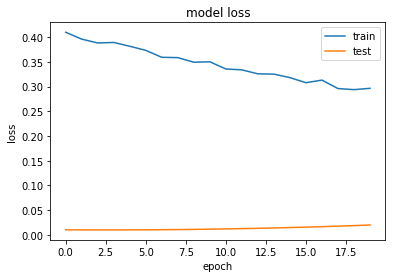

4
Train on 4 samples, validate on 3 samples
Epoch 1/20
 - 2s - loss: 0.3221 - val_loss: 0.0162
Epoch 2/20
 - 0s - loss: 0.3152 - val_loss: 0.0155
Epoch 3/20
 - 0s - loss: 0.3104 - val_loss: 0.0149
Epoch 4/20
 - 0s - loss: 0.3051 - val_loss: 0.0144
Epoch 5/20
 - 0s - loss: 0.3018 - val_loss: 0.0139
Epoch 6/20
 - 0s - loss: 0.2982 - val_loss: 0.0135
Epoch 7/20
 - 0s - loss: 0.2947 - val_loss: 0.0132
Epoch 8/20
 - 0s - loss: 0.2867 - val_loss: 0.0129
Epoch 9/20
 - 0s - loss: 0.2870 - val_loss: 0.0127
Epoch 10/20
 - 0s - loss: 0.2786 - val_loss: 0.0125
Epoch 11/20
 - 0s - loss: 0.2774 - val_loss: 0.0124
Epoch 12/20
 - 0s - loss: 0.2712 - val_loss: 0.0124
Epoch 13/20
 - 0s - loss: 0.2696 - val_loss: 0.0124
Epoch 14/20
 - 0s - loss: 0.2663 - val_loss: 0.0125
Epoch 15/20
 - 0s - loss: 0.2640 - val_loss: 0.0127
Epoch 16/20
 - 0s - loss: 0.2618 - val_loss: 0.0129
Epoch 17/20
 - 0s - loss: 0.2581 - val_loss: 0.0132
Epoch 18/20
 - 0s - loss: 0.2516 - val_loss: 0.0135
Epoch 19/20
 - 0s - loss: 0.2

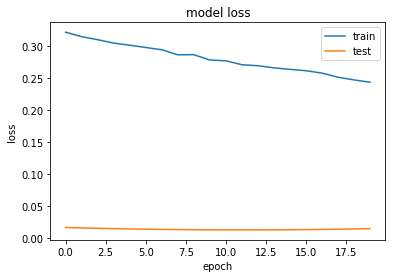

Hello lat and long
[[1.29040492]
 [1.28990761]
 [1.29040492]
 [1.29026146]
 [1.29015112]
 [1.29019071]
 [1.29010643]
 [1.2900866 ]
 [1.29025599]
 [1.29024537]
 [1.29031743]
 [1.29015458]
 [1.2901115 ]
 [1.28997368]
 [1.29022873]
 [1.29010774]
 [1.29018452]
 [1.29012935]
 [1.29009372]
 [1.28999485]
 [1.29032984]
 [1.28983372]
 [1.2902524 ]
 [1.29012794]
 [1.29024079]
 [1.28991414]
 [1.29039353]
 [1.28983304]
 [1.29009789]
 [1.29004641]
 [1.29010517]
 [1.29010727]
 [1.28978854]
 [1.29025121]
 [1.29018915]
 [1.28997368]
 [1.29010911]
 [1.28990236]
 [1.29010727]
 [1.29010727]
 [1.28986799]
 [1.29010429]
 [1.29023247]
 [1.29010727]
 [1.29009613]
 [1.28983304]
 [1.29010727]
 [1.2899713 ]
 [1.29010727]
 [1.29010727]
 [1.29010727]
 [1.290191  ]
 [1.28983304]
 [1.29022761]
 [1.29009915]
 [1.29026059]
 [1.29021261]
 [1.29025885]
 [1.290233  ]
 [1.29010727]
 [1.29011359]
 [1.28984046]
 [1.29019714]
 [1.29025388]
 [1.29009269]
 [1.28982505]
 [1.29020556]
 [1.29012428]
 [1.29021378]
 [1.29009546]
 

Train on 182 samples, validate on 78 samples
Epoch 1/20
 - 2s - loss: 0.3930 - val_loss: 0.2827
Epoch 2/20
 - 0s - loss: 0.3669 - val_loss: 0.2640
Epoch 3/20
 - 0s - loss: 0.3440 - val_loss: 0.2460
Epoch 4/20
 - 0s - loss: 0.3220 - val_loss: 0.2287
Epoch 5/20
 - 0s - loss: 0.2998 - val_loss: 0.2121
Epoch 6/20
 - 0s - loss: 0.2799 - val_loss: 0.1962
Epoch 7/20
 - 0s - loss: 0.2595 - val_loss: 0.1809
Epoch 8/20
 - 0s - loss: 0.2392 - val_loss: 0.1663
Epoch 9/20
 - 0s - loss: 0.2205 - val_loss: 0.1524
Epoch 10/20
 - 0s - loss: 0.2045 - val_loss: 0.1393
Epoch 11/20
 - 0s - loss: 0.1843 - val_loss: 0.1268
Epoch 12/20
 - 0s - loss: 0.1723 - val_loss: 0.1151
Epoch 13/20
 - 0s - loss: 0.1545 - val_loss: 0.1042
Epoch 14/20
 - 0s - loss: 0.1403 - val_loss: 0.0942
Epoch 15/20
 - 0s - loss: 0.1283 - val_loss: 0.0852
Epoch 16/20
 - 0s - loss: 0.1161 - val_loss: 0.0770
Epoch 17/20
 - 0s - loss: 0.1050 - val_loss: 0.0699
Epoch 18/20
 - 0s - loss: 0.0978 - val_loss: 0.0638
Epoch 19/20
 - 0s - loss: 0.

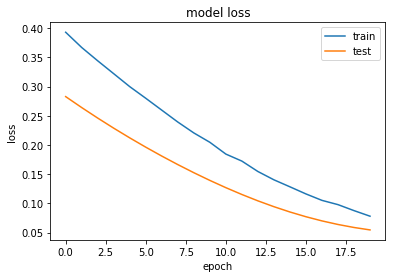

182
Train on 182 samples, validate on 78 samples
Epoch 1/20
 - 3s - loss: 0.4752 - val_loss: 0.3599
Epoch 2/20
 - 0s - loss: 0.4507 - val_loss: 0.3391
Epoch 3/20
 - 0s - loss: 0.4254 - val_loss: 0.3192
Epoch 4/20
 - 0s - loss: 0.4034 - val_loss: 0.3001
Epoch 5/20
 - 0s - loss: 0.3803 - val_loss: 0.2817
Epoch 6/20
 - 0s - loss: 0.3589 - val_loss: 0.2641
Epoch 7/20
 - 0s - loss: 0.3374 - val_loss: 0.2470
Epoch 8/20
 - 0s - loss: 0.3190 - val_loss: 0.2306
Epoch 9/20
 - 0s - loss: 0.2983 - val_loss: 0.2146
Epoch 10/20
 - 0s - loss: 0.2795 - val_loss: 0.1992
Epoch 11/20
 - 0s - loss: 0.2603 - val_loss: 0.1842
Epoch 12/20
 - 0s - loss: 0.2436 - val_loss: 0.1697
Epoch 13/20
 - 0s - loss: 0.2268 - val_loss: 0.1557
Epoch 14/20
 - 0s - loss: 0.2110 - val_loss: 0.1422
Epoch 15/20
 - 0s - loss: 0.1929 - val_loss: 0.1292
Epoch 16/20
 - 0s - loss: 0.1789 - val_loss: 0.1168
Epoch 17/20
 - 0s - loss: 0.1625 - val_loss: 0.1050
Epoch 18/20
 - 0s - loss: 0.1492 - val_loss: 0.0939
Epoch 19/20
 - 0s - loss

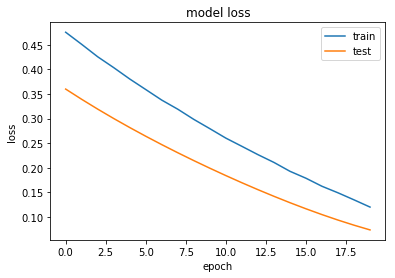

Hello lat and long
[[1.29001208]
 [1.29040492]
 [1.29001208]
 [1.29040492]
 [1.29038878]
 [1.29001208]
 [1.29040492]
 [1.29001208]
 [1.29040492]]
[[1.29001208]
 [1.29040492]
 [1.29001208]
 [1.29040492]
 [1.29038878]
 [1.29001208]
 [1.29040492]
 [1.29001208]
 [1.29040492]]
Hello scaled lat and long
[[0.       ]
 [1.       ]
 [0.       ]
 [1.       ]
 [0.9589155]
 [0.       ]
 [1.       ]
 [0.       ]
 [1.       ]]
[[0.       ]
 [1.       ]
 [0.       ]
 [1.       ]
 [0.9589155]
 [0.       ]
 [1.       ]
 [0.       ]
 [1.       ]]
5
Train on 5 samples, validate on 3 samples
Epoch 1/20
 - 3s - loss: 0.5716 - val_loss: 0.6617
Epoch 2/20
 - 0s - loss: 0.5659 - val_loss: 0.6565
Epoch 3/20
 - 0s - loss: 0.5688 - val_loss: 0.6515
Epoch 4/20
 - 0s - loss: 0.5618 - val_loss: 0.6465
Epoch 5/20
 - 0s - loss: 0.5496 - val_loss: 0.6415
Epoch 6/20
 - 0s - loss: 0.5413 - val_loss: 0.6366
Epoch 7/20
 - 0s - loss: 0.5426 - val_loss: 0.6318
Epoch 8/20
 - 0s - loss: 0.5309 - val_loss: 0.6270
Epoch 9/20
 -

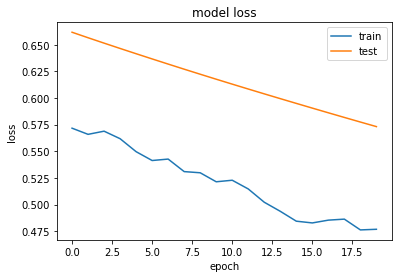

5
Train on 5 samples, validate on 3 samples
Epoch 1/20
 - 3s - loss: 0.4897 - val_loss: 0.6627
Epoch 2/20
 - 0s - loss: 0.4785 - val_loss: 0.6578
Epoch 3/20
 - 0s - loss: 0.4802 - val_loss: 0.6531
Epoch 4/20
 - 0s - loss: 0.4763 - val_loss: 0.6484
Epoch 5/20
 - 0s - loss: 0.4766 - val_loss: 0.6437
Epoch 6/20
 - 0s - loss: 0.4701 - val_loss: 0.6391
Epoch 7/20
 - 0s - loss: 0.4588 - val_loss: 0.6346
Epoch 8/20
 - 0s - loss: 0.4604 - val_loss: 0.6300
Epoch 9/20
 - 0s - loss: 0.4466 - val_loss: 0.6256
Epoch 10/20
 - 0s - loss: 0.4480 - val_loss: 0.6211
Epoch 11/20
 - 0s - loss: 0.4465 - val_loss: 0.6167
Epoch 12/20
 - 0s - loss: 0.4369 - val_loss: 0.6123
Epoch 13/20
 - 0s - loss: 0.4355 - val_loss: 0.6079
Epoch 14/20
 - 0s - loss: 0.4304 - val_loss: 0.6036
Epoch 15/20
 - 0s - loss: 0.4239 - val_loss: 0.5993
Epoch 16/20
 - 0s - loss: 0.4179 - val_loss: 0.5950
Epoch 17/20
 - 0s - loss: 0.4201 - val_loss: 0.5907
Epoch 18/20
 - 0s - loss: 0.4153 - val_loss: 0.5864
Epoch 19/20
 - 0s - loss: 0.4

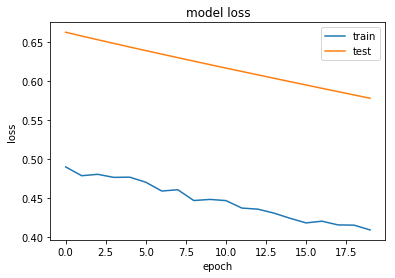

Hello lat and long
[[1.29021575]
 [1.29019873]
 [1.29024945]
 [1.29026371]
 [1.29019166]
 [1.2902191 ]
 [1.29022745]
 [1.29021335]
 [1.29022194]
 [1.29022745]
 [1.29022745]
 [1.29023804]
 [1.2902437 ]
 [1.29024367]
 [1.29023945]
 [1.2902311 ]
 [1.2902311 ]
 [1.29020861]
 [1.29020871]
 [1.29020871]
 [1.29020871]
 [1.29022108]
 [1.29022108]
 [1.29023131]
 [1.29022096]
 [1.29022096]
 [1.29022096]
 [1.29022467]
 [1.29022467]
 [1.29022812]
 [1.2902369 ]
 [1.29023688]
 [1.29023685]
 [1.29023685]
 [1.29022472]
 [1.29022467]
 [1.29022467]
 [1.29022467]
 [1.29022467]
 [1.29023688]
 [1.29024758]
 [1.29019876]
 [1.29019605]
 [1.29019912]
 [1.29017148]
 [1.29017124]
 [1.2901779 ]
 [1.29018845]
 [1.29017714]
 [1.2901808 ]
 [1.29018458]
 [1.29019239]
 [1.29017026]
 [1.29016124]
 [1.2901808 ]
 [1.29021493]
 [1.29019237]
 [1.29019508]
 [1.29018307]
 [1.29018307]
 [1.29019103]
 [1.29016525]
 [1.29016218]
 [1.29015415]
 [1.29018218]
 [1.29019443]
 [1.29017077]
 [1.29019443]
 [1.29019443]
 [1.29017444]
 

Train on 314 samples, validate on 135 samples
Epoch 1/20
 - 3s - loss: 0.1795 - val_loss: 0.4591
Epoch 2/20
 - 0s - loss: 0.1655 - val_loss: 0.4299
Epoch 3/20
 - 0s - loss: 0.1543 - val_loss: 0.4015
Epoch 4/20
 - 0s - loss: 0.1421 - val_loss: 0.3742
Epoch 5/20
 - 0s - loss: 0.1305 - val_loss: 0.3480
Epoch 6/20
 - 0s - loss: 0.1217 - val_loss: 0.3229
Epoch 7/20
 - 0s - loss: 0.1123 - val_loss: 0.2990
Epoch 8/20
 - 0s - loss: 0.1024 - val_loss: 0.2761
Epoch 9/20
 - 0s - loss: 0.0965 - val_loss: 0.2544
Epoch 10/20
 - 0s - loss: 0.0877 - val_loss: 0.2339
Epoch 11/20
 - 0s - loss: 0.0815 - val_loss: 0.2146
Epoch 12/20
 - 0s - loss: 0.0759 - val_loss: 0.1966
Epoch 13/20
 - 0s - loss: 0.0701 - val_loss: 0.1799
Epoch 14/20
 - 0s - loss: 0.0668 - val_loss: 0.1645
Epoch 15/20
 - 0s - loss: 0.0629 - val_loss: 0.1505
Epoch 16/20
 - 0s - loss: 0.0596 - val_loss: 0.1378
Epoch 17/20
 - 0s - loss: 0.0572 - val_loss: 0.1263
Epoch 18/20
 - 0s - loss: 0.0549 - val_loss: 0.1161
Epoch 19/20
 - 0s - loss: 0

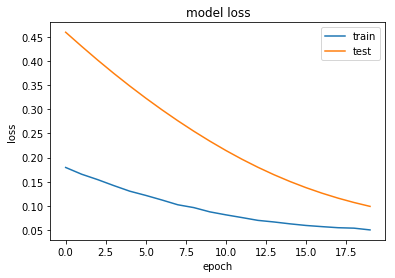

314
Train on 314 samples, validate on 135 samples
Epoch 1/20
 - 3s - loss: 0.1743 - val_loss: 0.4069
Epoch 2/20
 - 0s - loss: 0.1646 - val_loss: 0.3854
Epoch 3/20
 - 0s - loss: 0.1552 - val_loss: 0.3643
Epoch 4/20
 - 0s - loss: 0.1463 - val_loss: 0.3438
Epoch 5/20
 - 0s - loss: 0.1380 - val_loss: 0.3242
Epoch 6/20
 - 0s - loss: 0.1310 - val_loss: 0.3053
Epoch 7/20
 - 0s - loss: 0.1236 - val_loss: 0.2872
Epoch 8/20
 - 0s - loss: 0.1162 - val_loss: 0.2697
Epoch 9/20
 - 0s - loss: 0.1102 - val_loss: 0.2530
Epoch 10/20
 - 0s - loss: 0.1044 - val_loss: 0.2370
Epoch 11/20
 - 0s - loss: 0.0979 - val_loss: 0.2217
Epoch 12/20
 - 0s - loss: 0.0938 - val_loss: 0.2070
Epoch 13/20
 - 0s - loss: 0.0893 - val_loss: 0.1931
Epoch 14/20
 - 0s - loss: 0.0856 - val_loss: 0.1800
Epoch 15/20
 - 0s - loss: 0.0814 - val_loss: 0.1676
Epoch 16/20
 - 0s - loss: 0.0766 - val_loss: 0.1560
Epoch 17/20
 - 0s - loss: 0.0745 - val_loss: 0.1452
Epoch 18/20
 - 0s - loss: 0.0723 - val_loss: 0.1351
Epoch 19/20
 - 0s - los

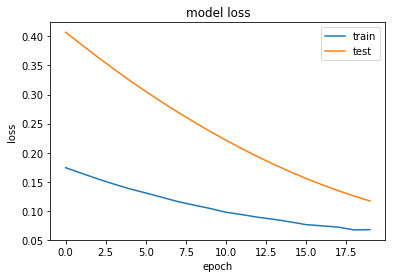

Hello lat and long
[[1.29023658]
 [1.29020664]
 [1.29028685]
 [1.29031206]
 [1.29030146]
 [1.29030133]
 [1.29030582]
 [1.29029685]
 [1.29027967]
 [1.29025638]
 [1.29025712]
 [1.2902412 ]
 [1.29025574]
 [1.29025616]
 [1.29025669]
 [1.29025596]
 [1.29024097]
 [1.29022878]
 [1.29023529]
 [1.29022909]
 [1.29022922]
 [1.2902159 ]
 [1.29020291]
 [1.29020056]
 [1.29019831]
 [1.29017479]
 [1.2901771 ]
 [1.29020278]
 [1.29019964]
 [1.29019605]
 [1.29021172]
 [1.29020841]
 [1.29019856]
 [1.29018934]
 [1.29019856]
 [1.29019539]
 [1.29018628]
 [1.29016901]
 [1.29017952]
 [1.29019608]
 [1.29018259]
 [1.29020285]
 [1.29018487]
 [1.29019959]
 [1.29017506]
 [1.29018981]
 [1.29018487]
 [1.29023282]
 [1.2902294 ]
 [1.29019959]
 [1.29022575]
 [1.29015044]
 [1.29016106]
 [1.2901781 ]
 [1.29016772]
 [1.29017303]
 [1.29015999]
 [1.29015999]
 [1.29015621]
 [1.29017162]
 [1.29017325]
 [1.29019291]
 [1.29016593]
 [1.29020208]
 [1.29023149]
 [1.29020907]
 [1.29020975]
 [1.29020939]
 [1.29021692]
 [1.29023944]
 

Train on 278 samples, validate on 120 samples
Epoch 1/20
 - 3s - loss: 0.1626 - val_loss: 0.5903
Epoch 2/20
 - 0s - loss: 0.1455 - val_loss: 0.5474
Epoch 3/20
 - 0s - loss: 0.1302 - val_loss: 0.5063
Epoch 4/20
 - 0s - loss: 0.1152 - val_loss: 0.4665
Epoch 5/20
 - 0s - loss: 0.1014 - val_loss: 0.4282
Epoch 6/20
 - 0s - loss: 0.0884 - val_loss: 0.3913
Epoch 7/20
 - 0s - loss: 0.0772 - val_loss: 0.3558
Epoch 8/20
 - 0s - loss: 0.0658 - val_loss: 0.3218
Epoch 9/20
 - 0s - loss: 0.0562 - val_loss: 0.2894
Epoch 10/20
 - 0s - loss: 0.0469 - val_loss: 0.2589
Epoch 11/20
 - 0s - loss: 0.0396 - val_loss: 0.2305
Epoch 12/20
 - 0s - loss: 0.0327 - val_loss: 0.2044
Epoch 13/20
 - 0s - loss: 0.0272 - val_loss: 0.1808
Epoch 14/20
 - 0s - loss: 0.0226 - val_loss: 0.1600
Epoch 15/20
 - 0s - loss: 0.0203 - val_loss: 0.1421
Epoch 16/20
 - 0s - loss: 0.0176 - val_loss: 0.1271
Epoch 17/20
 - 0s - loss: 0.0166 - val_loss: 0.1148
Epoch 18/20
 - 0s - loss: 0.0163 - val_loss: 0.1051
Epoch 19/20
 - 0s - loss: 0

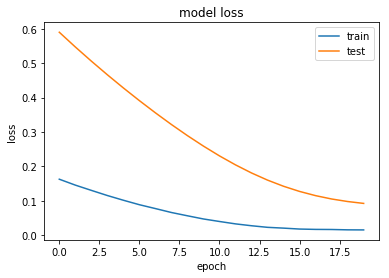

278
Train on 278 samples, validate on 120 samples
Epoch 1/20
 - 4s - loss: 0.1392 - val_loss: 0.5386
Epoch 2/20
 - 0s - loss: 0.1226 - val_loss: 0.4953
Epoch 3/20
 - 0s - loss: 0.1087 - val_loss: 0.4536
Epoch 4/20
 - 0s - loss: 0.0948 - val_loss: 0.4135
Epoch 5/20
 - 0s - loss: 0.0817 - val_loss: 0.3752
Epoch 6/20
 - 0s - loss: 0.0699 - val_loss: 0.3387
Epoch 7/20
 - 0s - loss: 0.0600 - val_loss: 0.3041
Epoch 8/20
 - 0s - loss: 0.0503 - val_loss: 0.2716
Epoch 9/20
 - 0s - loss: 0.0425 - val_loss: 0.2413
Epoch 10/20
 - 0s - loss: 0.0355 - val_loss: 0.2135
Epoch 11/20
 - 0s - loss: 0.0287 - val_loss: 0.1884
Epoch 12/20
 - 0s - loss: 0.0246 - val_loss: 0.1661
Epoch 13/20
 - 0s - loss: 0.0209 - val_loss: 0.1468
Epoch 14/20
 - 0s - loss: 0.0186 - val_loss: 0.1305
Epoch 15/20
 - 0s - loss: 0.0174 - val_loss: 0.1171
Epoch 16/20
 - 0s - loss: 0.0167 - val_loss: 0.1063
Epoch 17/20
 - 0s - loss: 0.0157 - val_loss: 0.0980
Epoch 18/20
 - 0s - loss: 0.0160 - val_loss: 0.0917
Epoch 19/20
 - 0s - los

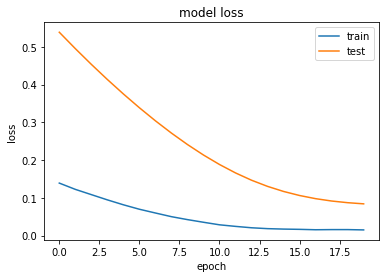

Hello lat and long
[[1.29058123]
 [1.29061627]
 [1.29058145]
 [1.29061756]
 [1.29058104]
 [1.29060815]
 [1.29059356]
 [1.29058367]
 [1.29065982]
 [1.2906381 ]
 [1.29062376]
 [1.29059241]
 [1.29058034]
 [1.29057619]
 [1.29057092]
 [1.29057918]
 [1.29060667]
 [1.2906415 ]
 [1.2906415 ]
 [1.29066042]
 [1.29070233]
 [1.290706  ]
 [1.29071354]
 [1.29072129]
 [1.29076378]
 [1.29078746]
 [1.29078421]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29078746]
 [1.29074102]
 [1.29057186]
 [1.29056053]
 [1.2905552 ]
 [1.29055923]
 [1.29055923]
 [1.29055923]
 [1.29056053]
 [1.29056053]
 [1.29056198]
 [1.29055805]
 [1.29055805]
 [1.29055699]
 [1.29055734]
 [1.29055734]
 [1.29055734]
 [1.29056106]
 [1.29055845]
 [1.29055504]
 [1.29055065]
 [1.29055688]
 [1.29055793]
 [1.29055793]
 [1.2905604 ]
 

Train on 389 samples, validate on 168 samples
Epoch 1/20
 - 4s - loss: 0.4070 - val_loss: 0.2225
Epoch 2/20
 - 0s - loss: 0.3580 - val_loss: 0.1901
Epoch 3/20
 - 0s - loss: 0.3134 - val_loss: 0.1601
Epoch 4/20
 - 0s - loss: 0.2704 - val_loss: 0.1324
Epoch 5/20
 - 0s - loss: 0.2306 - val_loss: 0.1070
Epoch 6/20
 - 0s - loss: 0.1960 - val_loss: 0.0839
Epoch 7/20
 - 0s - loss: 0.1616 - val_loss: 0.0635
Epoch 8/20
 - 0s - loss: 0.1298 - val_loss: 0.0459
Epoch 9/20
 - 0s - loss: 0.1015 - val_loss: 0.0315
Epoch 10/20
 - 0s - loss: 0.0779 - val_loss: 0.0204
Epoch 11/20
 - 0s - loss: 0.0580 - val_loss: 0.0128
Epoch 12/20
 - 0s - loss: 0.0416 - val_loss: 0.0082
Epoch 13/20
 - 0s - loss: 0.0330 - val_loss: 0.0063
Epoch 14/20
 - 0s - loss: 0.0247 - val_loss: 0.0063
Epoch 15/20
 - 0s - loss: 0.0199 - val_loss: 0.0074
Epoch 16/20
 - 0s - loss: 0.0163 - val_loss: 0.0089
Epoch 17/20
 - 0s - loss: 0.0150 - val_loss: 0.0103
Epoch 18/20
 - 0s - loss: 0.0139 - val_loss: 0.0113
Epoch 19/20
 - 0s - loss: 0

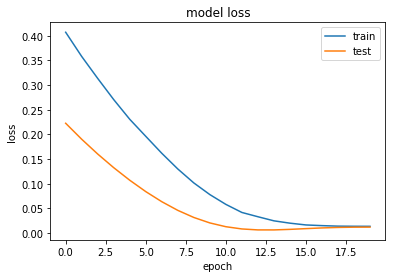

389
Train on 389 samples, validate on 168 samples
Epoch 1/20
 - 4s - loss: 0.4380 - val_loss: 0.2729
Epoch 2/20
 - 0s - loss: 0.3841 - val_loss: 0.2346
Epoch 3/20
 - 0s - loss: 0.3339 - val_loss: 0.1993
Epoch 4/20
 - 0s - loss: 0.2873 - val_loss: 0.1667
Epoch 5/20
 - 0s - loss: 0.2440 - val_loss: 0.1367
Epoch 6/20
 - 0s - loss: 0.2038 - val_loss: 0.1095
Epoch 7/20
 - 0s - loss: 0.1669 - val_loss: 0.0852
Epoch 8/20
 - 0s - loss: 0.1350 - val_loss: 0.0640
Epoch 9/20
 - 0s - loss: 0.1049 - val_loss: 0.0464
Epoch 10/20
 - 0s - loss: 0.0795 - val_loss: 0.0326
Epoch 11/20
 - 0s - loss: 0.0577 - val_loss: 0.0225
Epoch 12/20
 - 0s - loss: 0.0411 - val_loss: 0.0161
Epoch 13/20
 - 0s - loss: 0.0285 - val_loss: 0.0129
Epoch 14/20
 - 0s - loss: 0.0208 - val_loss: 0.0119
Epoch 15/20
 - 0s - loss: 0.0159 - val_loss: 0.0124
Epoch 16/20
 - 0s - loss: 0.0134 - val_loss: 0.0135
Epoch 17/20
 - 0s - loss: 0.0120 - val_loss: 0.0145
Epoch 18/20
 - 0s - loss: 0.0119 - val_loss: 0.0153
Epoch 19/20
 - 0s - los

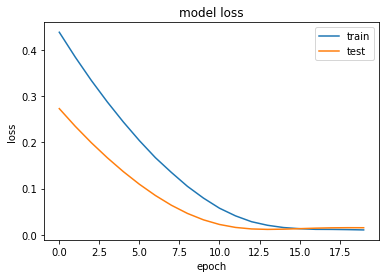

Hello lat and long
[[1.29069617]
 [1.2906476 ]
 [1.29065796]
 [1.2906134 ]
 [1.29066646]
 [1.2906403 ]
 [1.29062204]
 [1.29059713]
 [1.29059895]
 [1.29059895]
 [1.29058933]
 [1.29060872]
 [1.29058482]
 [1.29057557]
 [1.29057843]
 [1.29057843]
 [1.29056901]
 [1.29056695]
 [1.29056695]
 [1.29057629]
 [1.29059564]
 [1.29034525]
 [1.29034583]
 [1.29035544]
 [1.29035693]
 [1.29035404]
 [1.29035404]
 [1.29035404]
 [1.29039076]
 [1.290391  ]
 [1.29039218]
 [1.29039332]
 [1.29039218]
 [1.29039185]
 [1.2905729 ]
 [1.29057933]
 [1.29057933]
 [1.29057933]
 [1.29060162]
 [1.29060162]
 [1.29056699]
 [1.29058975]
 [1.29058975]
 [1.29058975]
 [1.29059584]
 [1.29061647]
 [1.29063693]
 [1.29063693]
 [1.29066581]
 [1.29063693]
 [1.29062455]
 [1.29062455]
 [1.29062054]
 [1.29062054]
 [1.29062054]
 [1.29062455]
 [1.29062455]
 [1.29062455]
 [1.29060663]
 [1.29060663]
 [1.29060663]
 [1.29063424]
 [1.29061753]
 [1.29061753]
 [1.29061753]
 [1.29060993]
 [1.29061434]
 [1.29060566]
 [1.2906207 ]
 [1.29062458]
 

Train on 256 samples, validate on 111 samples
Epoch 1/20
 - 4s - loss: 0.3751 - val_loss: 0.5355
Epoch 2/20
 - 0s - loss: 0.3470 - val_loss: 0.5010
Epoch 3/20
 - 0s - loss: 0.3231 - val_loss: 0.4681
Epoch 4/20
 - 0s - loss: 0.2991 - val_loss: 0.4365
Epoch 5/20
 - 0s - loss: 0.2773 - val_loss: 0.4060
Epoch 6/20
 - 0s - loss: 0.2553 - val_loss: 0.3764
Epoch 7/20
 - 0s - loss: 0.2347 - val_loss: 0.3478
Epoch 8/20
 - 0s - loss: 0.2150 - val_loss: 0.3200
Epoch 9/20
 - 0s - loss: 0.1949 - val_loss: 0.2932
Epoch 10/20
 - 0s - loss: 0.1751 - val_loss: 0.2671
Epoch 11/20
 - 0s - loss: 0.1595 - val_loss: 0.2421
Epoch 12/20
 - 0s - loss: 0.1422 - val_loss: 0.2182
Epoch 13/20
 - 0s - loss: 0.1259 - val_loss: 0.1955
Epoch 14/20
 - 0s - loss: 0.1127 - val_loss: 0.1740
Epoch 15/20
 - 0s - loss: 0.0994 - val_loss: 0.1540
Epoch 16/20
 - 0s - loss: 0.0850 - val_loss: 0.1356
Epoch 17/20
 - 0s - loss: 0.0744 - val_loss: 0.1189
Epoch 18/20
 - 0s - loss: 0.0654 - val_loss: 0.1039
Epoch 19/20
 - 0s - loss: 0

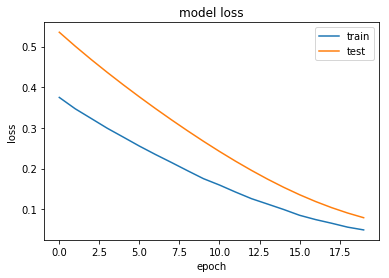

256
Train on 256 samples, validate on 111 samples
Epoch 1/20
 - 4s - loss: 0.2681 - val_loss: 0.4429
Epoch 2/20
 - 0s - loss: 0.2454 - val_loss: 0.4103
Epoch 3/20
 - 0s - loss: 0.2241 - val_loss: 0.3791
Epoch 4/20
 - 0s - loss: 0.2047 - val_loss: 0.3490
Epoch 5/20
 - 0s - loss: 0.1859 - val_loss: 0.3199
Epoch 6/20
 - 0s - loss: 0.1685 - val_loss: 0.2919
Epoch 7/20
 - 0s - loss: 0.1501 - val_loss: 0.2649
Epoch 8/20
 - 0s - loss: 0.1330 - val_loss: 0.2389
Epoch 9/20
 - 0s - loss: 0.1166 - val_loss: 0.2141
Epoch 10/20
 - 0s - loss: 0.1031 - val_loss: 0.1905
Epoch 11/20
 - 0s - loss: 0.0907 - val_loss: 0.1684
Epoch 12/20
 - 0s - loss: 0.0771 - val_loss: 0.1478
Epoch 13/20
 - 0s - loss: 0.0665 - val_loss: 0.1289
Epoch 14/20
 - 0s - loss: 0.0576 - val_loss: 0.1119
Epoch 15/20
 - 0s - loss: 0.0483 - val_loss: 0.0967
Epoch 16/20
 - 0s - loss: 0.0415 - val_loss: 0.0835
Epoch 17/20
 - 0s - loss: 0.0367 - val_loss: 0.0721
Epoch 18/20
 - 0s - loss: 0.0313 - val_loss: 0.0624
Epoch 19/20
 - 0s - los

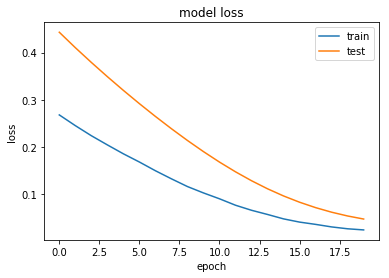

In [7]:
trajectory = predict_next_location_ext_user(36,"B1")

### The predicted trajectory(in terms of lat and long) for mac id 36 on level B1 is as follows:

In [8]:
trajectory

[(array([0.23356889], dtype=float32), array([0.2324574], dtype=float32)),
 (array([0.5209819], dtype=float32), array([0.40487352], dtype=float32)),
 (array([0.36866826], dtype=float32), array([0.45607218], dtype=float32)),
 (array([0.35708156], dtype=float32), array([0.32998845], dtype=float32)),
 (array([0.15145487], dtype=float32), array([0.15945959], dtype=float32)),
 (array([0.08149529], dtype=float32), array([0.07680465], dtype=float32)),
 (array([0.4991462], dtype=float32), array([0.36808005], dtype=float32)),
 (array([0.08339626], dtype=float32), array([0.08090115], dtype=float32)),
 (array([0.30959368], dtype=float32), array([0.24000353], dtype=float32)),
 (array([0.59006315], dtype=float32), array([0.6089355], dtype=float32)),
 (array([0.50361353], dtype=float32), array([0.4968422], dtype=float32)),
 (array([0.4531039], dtype=float32), array([0.50154155], dtype=float32))]